In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error
from codecarbon import EmissionsTracker
import matplotlib.dates as mdates
from sklearn.preprocessing import StandardScaler
import shape
import torch
import torch.nn as nn
from tqdm import tqdm
from torch.utils.data import TensorDataset, DataLoader

In [2]:
# Check the device for PyTorch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Additional GPU information
if torch.cuda.is_available():
    print(f"CUDA is available!")
    print(f"GPU Name: {torch.cuda.get_device_name(0)}")
    print(f"GPU Memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.1f} GB")
    print(f"Number of GPUs: {torch.cuda.device_count()}")
    print(f"Current GPU: {torch.cuda.current_device()}")
    
    # Clear GPU cache
    torch.cuda.empty_cache()
    
    # Set memory allocation strategy (optional)
    torch.cuda.set_per_process_memory_fraction(0.5)  # Use 50% of GPU memory
else:
    print("CUDA is not available. Using CPU.")

device

Using device: cuda
CUDA is available!
GPU Name: NVIDIA GeForce RTX 2050
GPU Memory: 4.3 GB
Number of GPUs: 1
Current GPU: 0


device(type='cuda')

In [3]:
df = pd.read_csv('data/all_data.csv', sep=',')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 414829 entries, 0 to 414828
Data columns (total 18 columns):
 #   Column                                                 Non-Null Count   Dtype  
---  ------                                                 --------------   -----  
 0   PRECIPITAÇÃO TOTAL, HORÁRIO (mm)                       414829 non-null  float64
 1   PRESSAO ATMOSFERICA AO NIVEL DA ESTACAO, HORARIA (mB)  414829 non-null  float64
 2   PRESSÃO ATMOSFERICA MAX.NA HORA ANT. (AUT) (mB)        414829 non-null  float64
 3   PRESSÃO ATMOSFERICA MIN. NA HORA ANT. (AUT) (mB)       414829 non-null  float64
 4   RADIACAO GLOBAL (Kj/m²)                                414829 non-null  float64
 5   TEMPERATURA DO AR - BULBO SECO, HORARIA (°C)           414829 non-null  float64
 6   TEMPERATURA DO PONTO DE ORVALHO (°C)                   414829 non-null  float64
 7   TEMPERATURA MÁXIMA NA HORA ANT. (AUT) (°C)             414829 non-null  float64
 8   TEMPERATURA MÍNIMA NA HORA ANT. (A

In [5]:
df['datetime'] = pd.to_datetime(df['datetime'])

df['year'] = df['datetime'].dt.year
df['month'] = df['datetime'].dt.month
df['day'] = df['datetime'].dt.day
df['hour'] = df['datetime'].dt.hour
df['minute'] = df['datetime'].dt.minute
df['second'] = df['datetime'].dt.second

input_data = df.drop([
    'datetime',
    'TEMPERATURA DO PONTO DE ORVALHO (°C)',
    'TEMPERATURA MÁXIMA NA HORA ANT. (AUT) (°C)',
    'TEMPERATURA MÍNIMA NA HORA ANT. (AUT) (°C)',
    'TEMPERATURA ORVALHO MAX. NA HORA ANT. (AUT) (°C)',
    'TEMPERATURA ORVALHO MIN. NA HORA ANT. (AUT) (°C)',
    'TEMPERATURA DO AR - BULBO SECO, HORARIA (°C)'], axis=1)
targets = df['TEMPERATURA DO AR - BULBO SECO, HORARIA (°C)'].values
T = 20                   
D = input_data.shape[1] 
N = len(input_data) - T

In [6]:
#Train size: 80% of the total data size
train_size = int(len(input_data) * 0.80)

# Normalization of the inputs
scaler = StandardScaler()
scaler.fit(input_data[:train_size + T - 1])
input_data = scaler.transform(input_data)

# Preparing X_train and y_train
X_train = np.zeros((train_size, T, D))
y_train = np.zeros((train_size, 1))

for t in range(train_size):
  X_train[t, :, :] = input_data[t:t+T]
  y_train[t] = (targets[t+T])

# Preparing X_test and y_test
X_test = np.zeros((N - train_size, T, D))
y_test = np.zeros((N - train_size, 1))

for i in range(N - train_size):
  t = i + train_size
  X_test[i, :, :] = input_data[t:t+T]
  y_test[i] = (targets[t+T])

# Make inputs and targets
X_train = torch.from_numpy(X_train.astype(np.float32))
y_train = torch.from_numpy(y_train.astype(np.float32))
X_test = torch.from_numpy(X_test.astype(np.float32))
y_test = torch.from_numpy(y_test.astype(np.float32))

In [7]:
class LSTM(nn.Module):
  def __init__(self, input_dim, hidden_dim, layer_dim, output_dim):
    super(LSTM, self).__init__()
    self.M = hidden_dim
    self.L = layer_dim

    self.rnn = nn.LSTM(
        input_size=input_dim,
        hidden_size=hidden_dim,
        num_layers=layer_dim,
        batch_first=True)
    #batch_first to have (batch_dim, seq_dim, feature_dim)
    self.fc = nn.Linear(hidden_dim, output_dim)

  def forward(self, X):
    # initial hidden state and cell state
    device = X.device  # Use the same device as input
    h0 = torch.zeros(self.L, X.size(0), self.M).to(device)
    c0 = torch.zeros(self.L, X.size(0), self.M).to(device)

    out, (hn, cn) = self.rnn(X, (h0.detach(), c0.detach()))

    # h(T) at the final time step
    out = self.fc(out[:, -1, :])
    return out

In [8]:
model = LSTM(input_dim=D, hidden_dim=256, layer_dim=2, output_dim=1)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

In [9]:
def train(model, learning_rate, X_train, y_train, X_test, y_test, epochs=100, batch_size=32):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-5)

    train_dataset = TensorDataset(X_train, y_train)
    test_dataset = TensorDataset(X_test, y_test)
    
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    train_losses = []
    test_losses = []

    for epoch in range(epochs):
        model.train()
        running_loss = 0.0

        for inputs, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}", leave=False):
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * inputs.size(0)

        epoch_loss = running_loss / len(train_loader.dataset)
        train_losses.append(epoch_loss)

        model.eval()
        test_loss = 0.0
        with torch.no_grad():
            for inputs, labels in test_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                test_loss += loss.item() * inputs.size(0)

        test_loss /= len(test_loader.dataset)
        test_losses.append(test_loss)

        print(f"Epoch [{epoch+1}/{epochs}] — Train Loss: {epoch_loss:.4f}, Test Loss: {test_loss:.4f}")

    return train_losses, test_losses

In [10]:
def return_rmse(model, X_test, y_test, batch_size=32):
    model.eval()
    device = next(model.parameters()).device
    
    # Clear GPU cache first
    if torch.cuda.is_available():
        torch.cuda.empty_cache()
    
    # Process in batches to avoid OOM
    predictions = []
    with torch.no_grad():
        for i in range(0, len(X_test), batch_size):
            batch_X = X_test[i:i+batch_size].to(device)
            batch_pred = model(batch_X).cpu()  # Move back to CPU immediately
            predictions.append(batch_pred)
            
            # Clear cache after each batch
            if torch.cuda.is_available():
                torch.cuda.empty_cache()
    
    # Concatenate all predictions
    y_pred = torch.cat(predictions, dim=0)
    y_true_np = y_test.cpu().numpy().flatten()
    y_pred_np = y_pred.numpy().flatten()

    rmse = np.sqrt(mean_squared_error(y_true_np, y_pred_np))
    return rmse

In [11]:
tracker = EmissionsTracker(
    project_name="PRECIPTATION lstm",
    output_file='codecarbon-lstm/codecarbon_emissions_prec.csv',
    log_level = "critical"
)

tracker.start()

train_losses, test_losses = train(
    model,
    learning_rate=0.01,
    X_train=X_train,
    y_train=y_train,
    X_test=X_test,
    y_test=y_test,
    epochs=25,
    batch_size=64
)

emissions: float = tracker.stop()
print(f"emissions={emissions}")

[codecarbon WARNING @ 19:33:30] Multiple instances of codecarbon are allowed to run at the same time.


Epoch [1/25] — Train Loss: 7.6034, Test Loss: 5.9063


Epoch [2/25] — Train Loss: 5.2750, Test Loss: 6.7576


Epoch [3/25] — Train Loss: 4.9675, Test Loss: 6.6105


Epoch [4/25] — Train Loss: 4.9694, Test Loss: 7.7957


Epoch [5/25] — Train Loss: 4.6337, Test Loss: 6.7631


Epoch [6/25] — Train Loss: 4.4783, Test Loss: 8.6883


Epoch [7/25] — Train Loss: 4.3795, Test Loss: 7.4573


Epoch [8/25] — Train Loss: 4.2328, Test Loss: 7.5991


Epoch [9/25] — Train Loss: 4.3194, Test Loss: 6.6715


Epoch [10/25] — Train Loss: 4.1768, Test Loss: 7.3287


Epoch [11/25] — Train Loss: 4.7093, Test Loss: 6.6367


Epoch [12/25] — Train Loss: 4.5462, Test Loss: 6.9937


Epoch [13/25] — Train Loss: 5.2061, Test Loss: 7.7811


Epoch [14/25] — Train Loss: 5.7681, Test Loss: 8.1396


Epoch [15/25] — Train Loss: 6.5489, Test Loss: 7.8227


Epoch [16/25] — Train Loss: 6.5412, Test Loss: 7.2327


Epoch [17/25] — Train Loss: 6.4322, Test Loss: 7.4815


Epoch [18/25] — Train Loss: 6.4805, Test Loss: 7.1243


Epoch [19/25] — Train Loss: 6.4176, Test Loss: 7.1737


Epoch [20/25] — Train Loss: 6.2869, Test Loss: 7.0358


Epoch [21/25] — Train Loss: 6.3169, Test Loss: 7.0465


Epoch [22/25] — Train Loss: 6.3357, Test Loss: 7.4071


Epoch [23/25] — Train Loss: 6.3640, Test Loss: 7.4614


Epoch [24/25] — Train Loss: 6.3309, Test Loss: 6.9688


Epoch [25/25] — Train Loss: 6.3281, Test Loss: 7.0289
emissions=0.002430988343578244


In [12]:
# Export the model to a pickle file
torch.save(model.state_dict(), 'lstm_temperature_model.pth')

In [13]:
def plot_dispersion(model, X_test, y_test, batch_size=32):
    model.eval()
    device = next(model.parameters()).device  # Get the model's device (CPU or CUDA)
    
    # Clear GPU cache first
    if torch.cuda.is_available():
        torch.cuda.empty_cache()
    
    # Process in batches to avoid OOM
    predictions = []
    with torch.no_grad():
        for i in range(0, len(X_test), batch_size):
            batch_X = X_test[i:i+batch_size].to(device)
            batch_pred = model(batch_X).cpu()  # Move back to CPU immediately
            predictions.append(batch_pred)
            
            # Clear cache after each batch
            if torch.cuda.is_available():
                torch.cuda.empty_cache()
    
    # Concatenate all predictions
    y_pred = torch.cat(predictions, dim=0)
    y_true_np = y_test.cpu().numpy().flatten()
    y_pred_np = y_pred.numpy().flatten()

    # Plotting
    plt.figure(figsize=(8, 8))
    plt.scatter(y_true_np, y_pred_np, alpha=0.7, color='blue')
    plt.xlabel('True Values')
    plt.ylabel('Predicted Values')
    plt.title('Dispersion Plot: True vs Predicted')
    plt.grid(True)
    plt.plot([y_true_np.min(), y_true_np.max()], [y_true_np.min(), y_true_np.max()], 'r--')  # Ideal line
    plt.tight_layout()
    plt.savefig('./plots/lstm_temp_dispersion.png')
    plt.show()

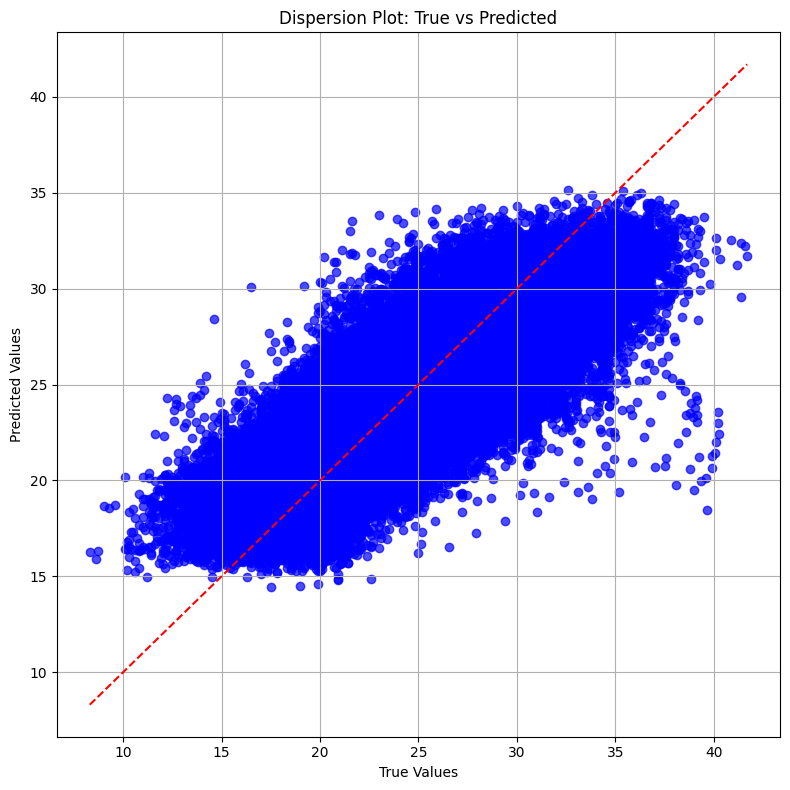

In [14]:
plot_dispersion(model, X_test, y_test)

In [15]:
# Limpar memória GPU antes de executar funções de plot
if torch.cuda.is_available():
    torch.cuda.empty_cache()
    print(f"GPU Memory before plotting: {torch.cuda.memory_allocated()/1e9:.2f} GB")
    print(f"GPU Memory cached: {torch.cuda.memory_reserved()/1e9:.2f} GB")
    print("✅ GPU cache cleared!")

GPU Memory before plotting: 0.02 GB
GPU Memory cached: 0.04 GB
✅ GPU cache cleared!


In [16]:
def plot_real_vs_predicted(model, X_test, y_test, batch_size=32):
    model.eval()
    device = next(model.parameters()).device  # Automatically get the model's device
    
    # Clear GPU cache first
    if torch.cuda.is_available():
        torch.cuda.empty_cache()
    
    # Process in batches to avoid OOM
    predictions = []
    with torch.no_grad():
        for i in range(0, len(X_test), batch_size):
            batch_X = X_test[i:i+batch_size].to(device)
            batch_pred = model(batch_X).cpu()  # Move back to CPU immediately
            predictions.append(batch_pred)
            
            # Clear cache after each batch
            if torch.cuda.is_available():
                torch.cuda.empty_cache()
    
    # Concatenate all predictions
    y_pred = torch.cat(predictions, dim=0)
    y_true_np = y_test.cpu().numpy().flatten()
    y_pred_np = y_pred.numpy().flatten()

    # Plot real vs predicted
    plt.figure(figsize=(12, 6))
    plt.plot(y_true_np, label='Real', linewidth=2)
    plt.plot(y_pred_np, label='Predicted', linewidth=2)
    plt.title('Real vs Predicted Values')
    plt.xlabel('Sample Index')
    plt.ylabel('Value')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.savefig('./plots/lstm_temp_real_x_pred.png')
    plt.show()

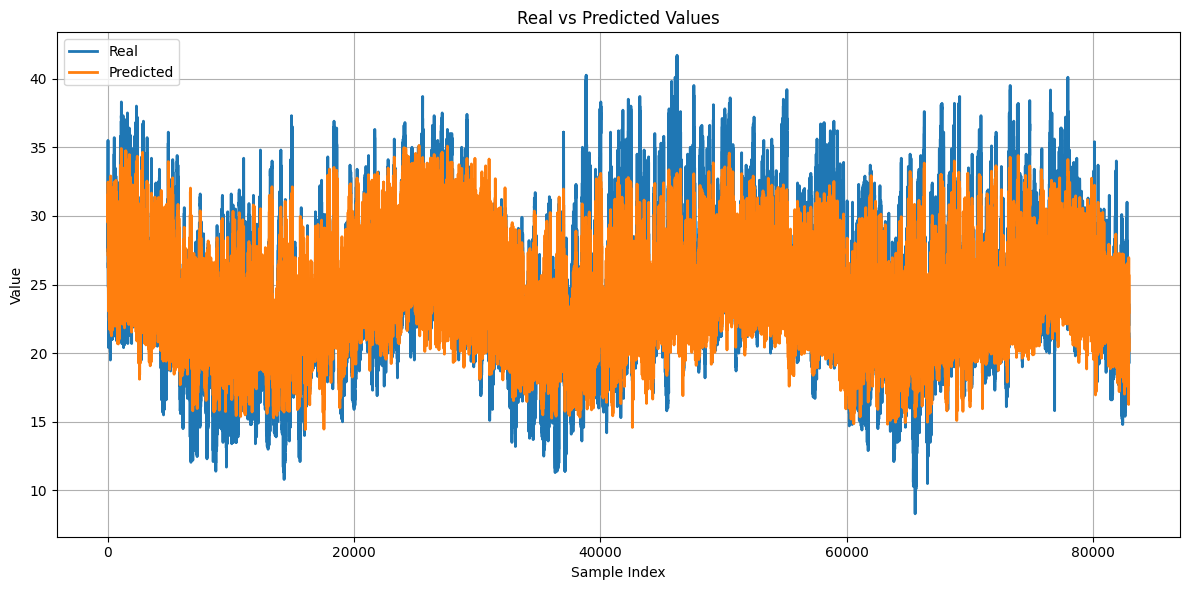

In [17]:
plot_real_vs_predicted(model, X_test, y_test)

In [18]:
def print_rmse(model, X_test, y_test, batch_size=32):
    model.eval()
    device = next(model.parameters()).device
    
    # Clear GPU cache first
    if torch.cuda.is_available():
        torch.cuda.empty_cache()
    
    # Process in batches to avoid OOM
    predictions = []
    with torch.no_grad():
        for i in range(0, len(X_test), batch_size):
            batch_X = X_test[i:i+batch_size].to(device)
            batch_pred = model(batch_X).cpu()  # Move back to CPU immediately
            predictions.append(batch_pred)
            
            # Clear cache after each batch
            if torch.cuda.is_available():
                torch.cuda.empty_cache()
    
    # Concatenate all predictions
    y_pred = torch.cat(predictions, dim=0)
    y_true_np = y_test.cpu().numpy().flatten()
    y_pred_np = y_pred.numpy().flatten()

    rmse = np.sqrt(mean_squared_error(y_true_np, y_pred_np))
    print(f"RMSE: {rmse:.4f}")

In [19]:
print_rmse(model, X_test, y_test)

RMSE: 2.6512


In [20]:
def plot_lstm_prediction_over_time(model, X_test, y_test, timestamps, start_date=None, end_date=None, save=False, batch_size=32):
    model.eval()
    device = next(model.parameters()).device

    # Clear GPU cache first
    if torch.cuda.is_available():
        torch.cuda.empty_cache()
    
    # Process in batches to avoid OOM
    predictions = []
    with torch.no_grad():
        for i in range(0, len(X_test), batch_size):
            batch_X = X_test[i:i+batch_size].to(device)
            batch_pred = model(batch_X).cpu()  # Move back to CPU immediately
            predictions.append(batch_pred)
            
            # Clear cache after each batch
            if torch.cuda.is_available():
                torch.cuda.empty_cache()
    
    # Concatenate all predictions
    y_pred = torch.cat(predictions, dim=0)
    y_true_np = y_test.cpu().numpy().flatten()
    y_pred_np = y_pred.numpy().flatten()
    timestamps = pd.to_datetime(timestamps)

    data = pd.DataFrame({
        'Timestamp': timestamps,
        'Actual': y_true_np,
        'Predicted': y_pred_np
    })

    if start_date:
        data = data[data['Timestamp'] >= pd.to_datetime(start_date)]
    if end_date:
        data = data[data['Timestamp'] <= pd.to_datetime(end_date)]

    plt.figure(figsize=(12, 6))
    plt.plot(data['Timestamp'], data['Actual'], label='Actual Values', color='blue', linewidth=2)
    plt.plot(data['Timestamp'], data['Predicted'], label='Predicted Values', color='orange', linewidth=2)
    plt.xlabel('Time')
    plt.ylabel('Values')
    plt.title('LSTM: Actual vs. Predicted Values Over Time')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()

    if save:
        plt.savefig(save)

    plt.show()

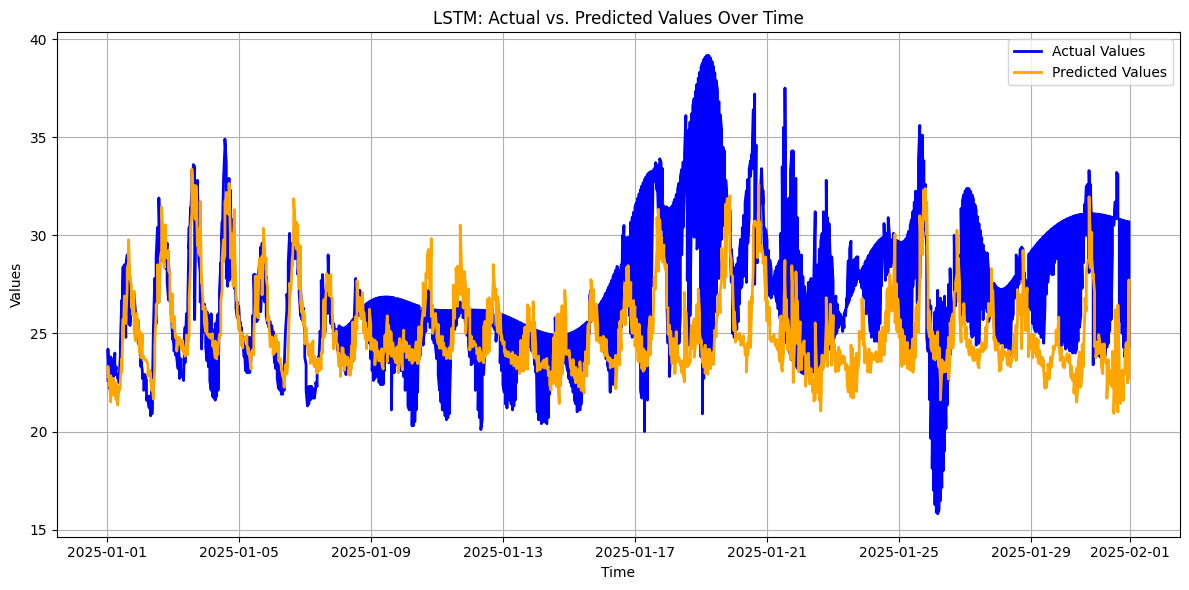

In [21]:
start_date = "2025-01-01 01:00:00"
end_date = "2025-01-31 23:00:00"

timestamps = pd.to_datetime(df['datetime'])
timestamps_for_plot = timestamps[T:T + N]
timestamps_test = timestamps_for_plot[train_size:]

plot_lstm_prediction_over_time(model, X_test, y_test, timestamps_test,start_date, end_date, save='./plots/lstm_temp_rvp.png')